In [1]:
from src.datasets.brats_tumor_vol_datamodule import BraTSDataModule
import yaml

import torch
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import ImageGrid

In [2]:
%matplotlib inline


train loader data torch.Size([1, 4, 128, 128, 128])
train loader mask torch.Size([1, 3, 128, 128, 128])
train loader patch vols [torch.Size([1, 3, 64, 64, 64]), torch.Size([1, 3, 32, 32, 32]), torch.Size([1, 3, 16, 16, 16]), torch.Size([1, 3, 8, 8, 8]), torch.Size([1, 3, 4, 4, 4])]


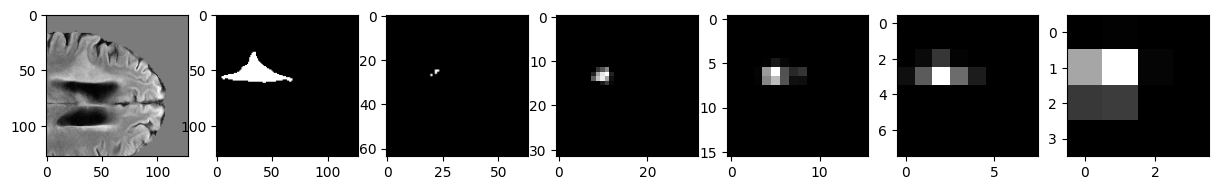

In [15]:
with open('/home/sanyal/Projects/BraTS3DDiff/configs/data/brats23.yaml') as f:
    cfg = yaml.safe_load(f)
cfg.pop('_target_')
cfg['data_dir'] = '/home/sanyal/Projects/BraTS3DDiff/data/BraTS-Data/BraTS2024-GLI'
cfg['patch_sizes'] = [2,4,8,16,32]
a = BraTSDataModule(**cfg)

train_data = a.train_dataloader()
data = iter(train_data).__next__()
image = data["image"]
print("train loader data", image.shape)
mask = data["mask"]
print("train loader mask", mask.shape)
b,c,w,h,d = mask.shape
patch_vols = data['volume_map']
print("train loader patch vols", [patch_vols[i].shape for i in range(len(patch_vols))])

fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 5))
axes[0].imshow(image[0,0,:,:,78],cmap='gray')
axes[1].imshow(mask[0,0,:,:,78],cmap='gray')
for i,patch_vol in enumerate(patch_vols):
    axes[i+2].imshow(patch_vol[0,0,:,:,patch_vol.shape[-1]//2],cmap='gray')

In [13]:
patch_vol

metatensor([[[[[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0275, 0.0028],
           [0.0000, 0.0908, 0.1560, 0.0358],
           [0.0000, 0.1642, 0.0012, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000]]],


         [[[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0083, 0.0000],
           [0.0000, 0.0000, 0.0009, 0.0000]],

          [[0.0000, 0.0000, 0.0000, 0.0000],
           [0.0000, 0.0000, 0.0000, 0.0

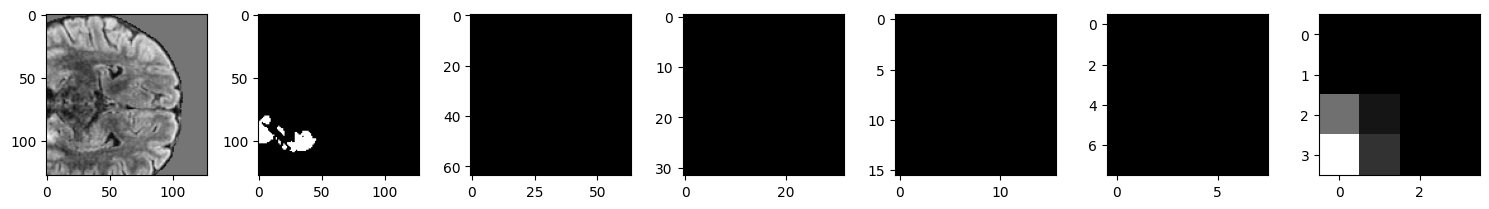

In [9]:
fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 5))
axes[0].imshow(image[0,0,:,:,78],cmap='gray')
axes[1].imshow(mask[0,0,:,:,78],cmap='gray')
for i,patch_vol in enumerate(patch_vols):
    axes[i+2].imshow(patch_vol[0,0,:,:,2],cmap='gray')


fig.tight_layout()

torch.Size([128, 128]) torch.Size([3, 128, 128])


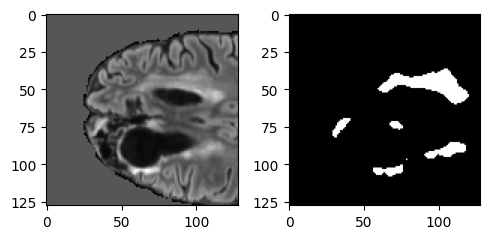

In [4]:
#visualize patches
im_channel=0
depth=78
image = image[0,im_channel,:,:,depth]
mask = mask[0,:,:,:,depth]
print(image.shape,mask.shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(image,cmap='gray')
axes[1].imshow(mask[0],cmap='gray')
fig.tight_layout()

train loader data torch.Size([1, 4, 128, 128, 128])
train loader mask torch.Size([1, 3, 128, 128, 128])
train loader patch vols [torch.Size([1, 3, 64, 64, 64]), torch.Size([1, 3, 32, 32, 32]), torch.Size([1, 3, 16, 16, 16]), torch.Size([1, 3, 8, 8, 8]), torch.Size([1, 3, 4, 4, 4])]
torch.Size([128, 128]) torch.Size([3, 128, 128])


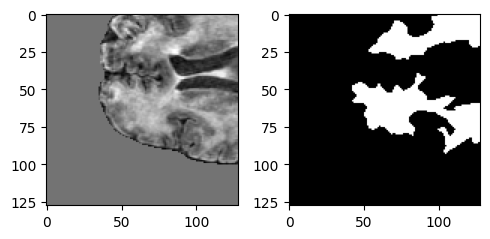

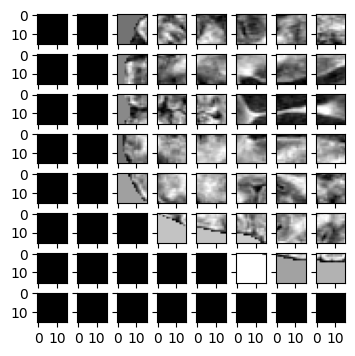

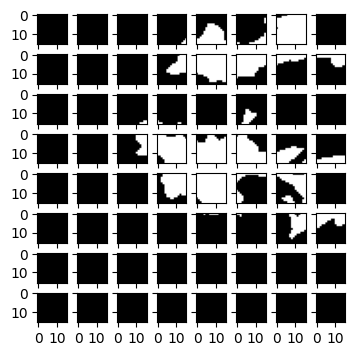

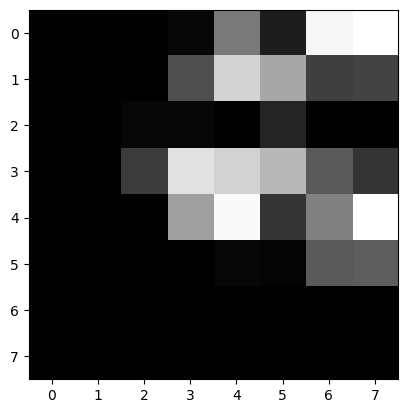

In [4]:
with open('/home/sanyal/Projects/BraTS3DDiff/configs/data/brats23.yaml') as f:
    cfg = yaml.safe_load(f)
cfg.pop('_target_')
cfg['data_dir'] = '/home/sanyal/Projects/BraTS3DDiff/data/BraTS-Data/BraTS2024-GLI'
cfg['patch_sizes'] = [2,4,8,16,32]
a = BraTSDataModule(**cfg)

train_data = a.train_dataloader()
data = iter(train_data).__next__()
image = data["image"]
print("train loader data", image.shape)
mask = data["mask"]
print("train loader mask", mask.shape)
patch_vols = data['volume_map']
print("train loader patch vols", [patch_vols[i].shape for i in range(len(patch_vols))])

#visualize patches
im_channel=0
depth=78
image = image[0,im_channel,:,:,depth]
mask = mask[0,:,:,:,depth]
print(image.shape,mask.shape)

fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(5, 3))
axes[0].imshow(image,cmap='gray')
axes[1].imshow(mask[0],cmap='gray')
fig.tight_layout()

w,h = image.shape
c,w,h = mask.shape
patch_size = cfg['patch_sizes'][-2]

img_patches = image.view(w//patch_size,patch_size,h//patch_size,patch_size)
mask_patches = mask.view(c,w//patch_size,patch_size,h//patch_size,patch_size)
mask_patches_vol = mask_patches[0].sum(dim=(1,3))


fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(w//patch_size, h//patch_size),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (w//patch_size, h//patch_size)
#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    patch_index = (idx//grid_h, idx%grid_h)
    #print('patch_index_1',indices[idx])
    ax.imshow(img_patches[patch_index[0],:,patch_index[1],:],cmap='gray')

plt.show()
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(w//patch_size, h//patch_size),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (w//patch_size, h//patch_size)
#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    patch_index = (idx//grid_h, idx%grid_h)
    #print('patch_index_1',indices[idx])
    ax.imshow(mask_patches[0, patch_index[0],:,patch_index[1],:],cmap='gray')
plt.show()

fig,ax = plt.subplots(1,1)
ax.imshow(mask_patches_vol,cmap='gray')

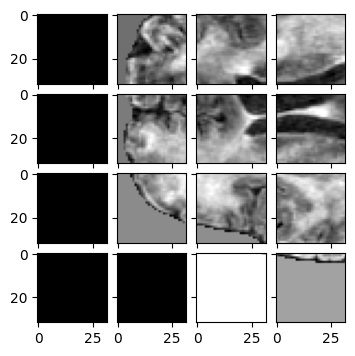

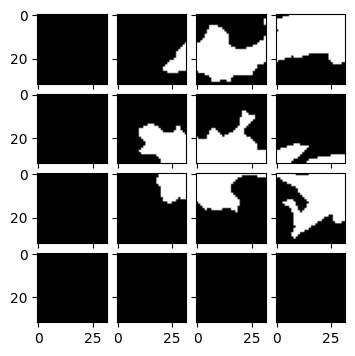

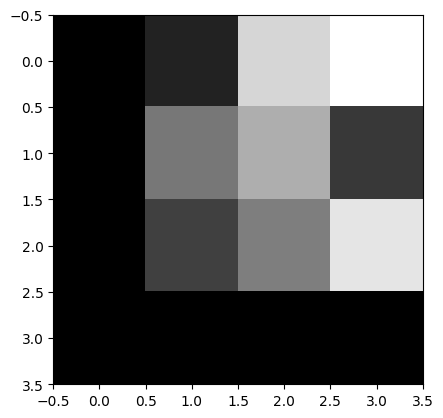

In [13]:
w,h = image.shape
c,w,h = mask.shape
patch_size = cfg['patch_sizes'][-1]

img_patches = image.view(w//patch_size,patch_size,h//patch_size,patch_size)
mask_patches = mask.view(c,w//patch_size,patch_size,h//patch_size,patch_size)
mask_patches_vol = mask_patches[0].sum(dim=(1,3))/(patch_size*patch_size)


fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(w//patch_size, h//patch_size),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (w//patch_size, h//patch_size)
#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    patch_index = (idx//grid_h, idx%grid_h)
    #print('patch_index_1',indices[idx])
    ax.imshow(img_patches[patch_index[0],:,patch_index[1],:],cmap='gray')

plt.show()
fig = plt.figure(figsize=(4., 4.))
grid = ImageGrid(fig, 111,  # similar to subplot(111)
                nrows_ncols=(w//patch_size, h//patch_size),  # creates 2x2 grid of Axes
                axes_pad=0.1,  # pad between Axes in inch.
                )

grid_w,grid_h = (w//patch_size, h//patch_size)
#indices = torch.cartesian_prod(torch.arange(grid_w),torch.arange(grid_h))
for idx, ax in enumerate(grid):
    # Iterating over the grid returns the Axes.
    patch_index = (idx//grid_h, idx%grid_h)
    #print('patch_index_1',indices[idx])
    ax.imshow(mask_patches[0, patch_index[0],:,patch_index[1],:],cmap='gray')
plt.show()

fig,ax = plt.subplots(1,1)
ax.imshow(mask_patches_vol,cmap='gray')

In [14]:
mask_patches_vol

metatensor([[0.0000, 0.0830, 0.5166, 0.6172],
        [0.0000, 0.2891, 0.4209, 0.1377],
        [0.0000, 0.1553, 0.3047, 0.5537],
        [0.0000, 0.0000, 0.0000, 0.0000]])

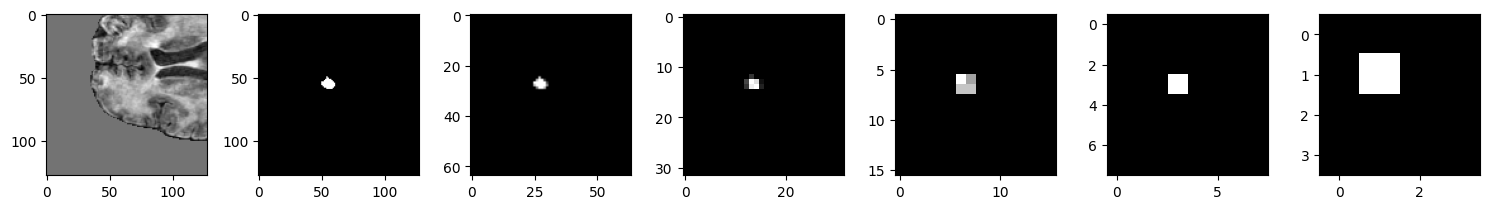

In [20]:


fig, axes = plt.subplots(nrows=1, ncols=7, figsize=(15, 5))
axes[0].imshow(image,cmap='gray')
axes[1].imshow(mask[1],cmap='gray')
for i in range(len(cfg['patch_sizes'])):
    patch_size = cfg['patch_sizes'][i]
    mask_patches = mask.view(c,w//patch_size,patch_size,h//patch_size,patch_size)
    mask_patches_vol = mask_patches[1].sum(dim=(1,3))
    axes[i+2].imshow(mask_patches_vol,cmap='gray')


fig.tight_layout()


In [21]:
mask_patches_vol

metatensor([[ 0,  0,  0,  0],
        [ 0, 70,  0,  0],
        [ 0,  0,  0,  0],
        [ 0,  0,  0,  0]])

In [17]:
mask.shape

torch.Size([3, 128, 128])

In [7]:
patch_size=32
mask_patches = mask.view(c,w//patch_size,patch_size,h//patch_size,patch_size)
mask_patches_vol = mask_patches[0].sum(dim=(1,3))

In [8]:
mask_patches_vol

metatensor([[  0,  85, 529, 632],
        [  0, 296, 431, 141],
        [  0, 159, 312, 567],
        [  0,   0,   0,   0]])

In [10]:
32*32

1024

In [ ]:
mask_patches_vol